In [275]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import pickle
import timeit
import time

from pathlib import Path

from matplotlib.widgets import Slider
from matplotlib.colors import LogNorm
import matplotlib.animation as animation
from fa2 import ForceAtlas2

# Visualize Object Graph

In [305]:
dataset = "./result/exp1_prcc_buildats/roc-collect"
# dataset = "./result/exp1_prcc_itsttime/roc-collect"
# dataset = "./result/exp1_prcc_storesfg/roc-collect"

In [306]:
feature_paths = [
    f"{dataset}/feature.csv",
]
dff = pd.concat([pd.read_csv(feature_path) for feature_path in feature_paths], ignore_index=True)
dff

Unnamed: 0          oid  global   type  type_global  \
0                0  13131854016   False   dict        False   
1                1   4385088304   False    str        False   
2                2  13124358000   False    int        False   
3                3  13040086608   False  PodId        False   
4                4   5332663616   False   type        False   
...            ...          ...     ...    ...          ...   
210339      210339  13393240208   False    int        False   
210340      210340  13392864768   False   dict        False   
210341      210341  13393240816   False    int        False   
210342      210342  13393240496   False    int        False   
210343      210343  13393204336   False    int        False   

        type_pickler_dispatch  type_subclass_type type_module  \
0                       False               False    builtins   
1                       False               False    builtins   
2                       False               False    builtins   
3                       False               False  pod.common   
4                       False                True    builtins   
...                       ...                 ...         ...   
210339                  False               False    builtins   
210340                  False               False    builtins   
210341                  False               False    builtins   
210342                  False               False    builtins   
210343                  False               False    builtins   

        type_module_global  has_reduce_ex  has_reduce  size   len  len_dict  \
0                     True           True        True  1584  72.0       NaN   
1                     True           True        True    57   8.0       NaN   
2                     True           True        True    32   NaN       NaN   
3                    False           True        True    56   NaN       2.0   
4                     True           True        True  1688   NaN      17.0   
...                    ...            ...         ...   ...   ...       ...   
210339                True           True        True    32   NaN       NaN   
210340                True           True        True   184   1.0       NaN   
210341                True           True        True    32   NaN       NaN   
210342                True           True        True    32   NaN       NaN   
210343                True           True        True    32   NaN       NaN   

        len_slots  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           ...  
210339        NaN  
210340        NaN  
210341        NaN  
210342        NaN  
210343        NaN  

[210344 rows x 15 columns]

In [307]:
change_paths = [
    f"{dataset}/change.csv",
]
dfc = pd.concat([pd.read_csv(change_path) for change_path in change_paths], ignore_index=True)
dfc

Unnamed: 0          oid     root_oid  nth  dump_th  has_changed
0                 0  13131854016            0    0        0         True
1                 1   4385088304   4385088304    0        0         True
2                 2  13124358000            0    0        0         True
3                 3  13040086608  13040086608    0        0         True
4                 4   5332663616   5332663616    0        0         True
...             ...          ...          ...  ...      ...          ...
2963562     2963562  13393240208  13392176832    0       41         True
2963563     2963563  13392864768  13392864768    0       41        False
2963564     2963564  13393240816  13392864768    0       41        False
2963565     2963565  13393240496  13392176832    0       41         True
2963566     2963566  13393204336  13347779088    0       41         True

[2963567 rows x 6 columns]

In [308]:
dep_paths = [
    f"{dataset}/dep.csv",
]
dfd = pd.concat([pd.read_csv(dep_path) for dep_path in dep_paths], ignore_index=True)
dfd

Unnamed: 0  nth  dump_th  from_root_oid  to_root_oid
0                0    0        0              0   5547963152
1                1    0        0              0   5562320656
2                2    0        0              0   6065048336
3                3    0        0              0   6065047312
4                4    0        0              0   6065050384
...            ...  ...      ...            ...          ...
157028      157028    0       41    13392176832   4388359920
157029      157029    0       41    13368940032   4415907312
157030      157030    0       41    13368940032   4384633408
157031      157031    0       41    13368940032  13148554496
157032      157032    0       41    13368940032   4385094888

[157033 rows x 5 columns]

In [309]:
var_paths = [
    f"{dataset}/var.csv",
]
dfv = pd.concat([pd.read_csv(var_path) for var_path in var_paths], ignore_index=True)
dfv

Unnamed: 0  dump_th          varname          oid
0              0        0         __spec__   4385056096
1              1        0     __builtins__   4371892800
2              2        0               os   4372280512
3              3        0               np   4428342640
4              4        0               pd   5018427984
...          ...      ...              ...          ...
4035        4035       41       df_tr2_ICA  13327981904
4036        4036       41  df_tr2_ICA_sca0   6061869200
4037        4037       41  df_tr2_ICA_sca1   6121706064
4038        4038       41  df_tr2_ICA_sca2  13334904976
4039        4039       41  df_tr2_ICA_sca3  13347779088

[4040 rows x 4 columns]

In [310]:
if (dfc.oid != dfc.root_oid).sum() > 0:
    print(f"{(dfc.oid != dfc.root_oid).sum()} mismatches, filtering them out")
    dfc = dfc[dfc.oid == dfc.root_oid]

2609728 mismatches, filtering them out


## Assign Coordinates then Plot

In [311]:
# dfc = dfc[dfc["nth"] < 5]
# dfd = dfd[dfd["nth"] < 5]

In [312]:
dfc.loc[dfc["nth"] == 0, "has_changed"] = True

In [313]:
all_node_ids = set(dfc["oid"].values)
edge_df = dfd[dfd["from_root_oid"].isin(all_node_ids) & dfd["to_root_oid"].isin(all_node_ids)]
all_node_ids = (
    set(dfc["oid"].values)
    & (set(edge_df["from_root_oid"].values) | set(edge_df["to_root_oid"].values))
)
edge_df = dfd[dfd["from_root_oid"].isin(all_node_ids) & dfd["to_root_oid"].isin(all_node_ids)]
all_edges = set((row["from_root_oid"], row["to_root_oid"]) for _, row in edge_df.iterrows())
all_node_ids = list(all_node_ids)
print(f"Extracted {len(all_node_ids)} nodes with {len(all_edges)} edges")

Extracted 23317 nodes with 74426 edges


In [314]:
for vname in dfv["varname"].unique():
    print(f"'{vname}',")

'__spec__',
'__builtins__',
'os',
'np',
'pd',
'sns',
'make_subplots',
'go',
'px',
'plt',
'cm',
'read_csv',
'set_option',
'StandardScaler',
'MinMaxScaler',
'Normalizer',
'RobustScaler',
'train_test_split',
'KFold',
'cross_val_score',
'GridSearchCV',
'LogisticRegression',
'DecisionTreeClassifier',
'KNeighborsClassifier',
'LinearDiscriminantAnalysis',
'GaussianNB',
'SVC',
'MLPClassifier',
'CatBoostClassifier',
'CatBoostRegressor',
'RandomForestClassifier',
'RandomForestRegressor',
'SelectKBest',
'f_regression',
'plot_importance',
'XGBClassifier',
'XGBRegressor',
'learning_curve',
'Pipeline',
'AdaBoostClassifier',
'GradientBoostingClassifier',
'ExtraTreesClassifier',
'classification_report',
'confusion_matrix',
'accuracy_score',
'preprocessing',
'shap',
'PCA',
'SparsePCA',
'KernelPCA',
'IncrementalPCA',
'TruncatedSVD',
'MiniBatchDictionaryLearning',
'FastICA',
'Isomap',
'MDS',
'LocallyLinearEmbedding',
'TSNE',
'GaussianRandomProjection',
'SparseRandomProjection',
'time',
'warnings',
'plot_

In [315]:
selected_names = {
    '__spec__',
    '__builtins__',
    '__warningregistry__',
    '__doc__',

    # imports
    'os',
    'np',
    'pd',
    'sns',
    'go',
    'px',
    'plt',
    'time',
    'warnings',
    'datetime',
    'pytz',
    'dateparse',
    'shap',

    # pandas
    'read_csv',

    # plots
    'cm',
    'make_subplots',
    'set_option',

    # scikit-learns
    'StandardScaler',
    'MinMaxScaler',
    'Normalizer',
    'RobustScaler',
    'train_test_split',
    'KFold',
    'cross_val_score',
    'GridSearchCV',
    'LogisticRegression',
    'DecisionTreeClassifier',
    'KNeighborsClassifier',
    'LinearDiscriminantAnalysis',
    'GaussianNB',
    'SVC',
    'MLPClassifier',
    'CatBoostClassifier',
    'CatBoostRegressor',
    'RandomForestClassifier',
    'RandomForestRegressor',
    'SelectKBest',
    'f_regression',
    'plot_importance',
    'XGBClassifier',
    'XGBRegressor',
    'learning_curve',
    'Pipeline',
    'AdaBoostClassifier',
    'GradientBoostingClassifier',
    'ExtraTreesClassifier',
    'classification_report',
    'confusion_matrix',
    'accuracy_score',
    'preprocessing',
    'PCA',
    'SparsePCA',
    'KernelPCA',
    'IncrementalPCA',
    'TruncatedSVD',
    'MiniBatchDictionaryLearning',
    'FastICA',
    'Isomap',
    'MDS',
    'LocallyLinearEmbedding',
    'TSNE',
    'GaussianRandomProjection',
    'SparseRandomProjection',

    # defined functions
    'plot_line',
    'plot_vsubplots',
    'colours',
    'plot_line2',
    'cmap',
    'corrMat',
    'bar_plot',
    'scatterPlot',
    'red_mem',
    'TimeSeries_Split',

    # data
    'plot_period',
    'data_period',
    'path',
    'df',
    'df_tr',
    'df_te',
    'NaN_values',
    'forward_fill_na',
    'create_target',
    'df_tr1',
    'df_te1',
    'lst_MAV',
    'ldf',
    'df_tr2',
    'df_te2',
    'ma',
    'ema',
    'mom',
    'roc',
    'rsi',
    'sto',
    'tech_indi',
    'drp_feat',
    'models',
    'modelEval',
    'fi',
    'df_tr2_FI',
}

vname_map_at = {}
oids_at = {
    dump_th: set(dfc[dfc["dump_th"] == dump_th].oid.values)
    for dump_th in set(dfc.dump_th.values)
}
for _, row in dfv.iterrows():
    oids = oids_at[row.dump_th]
    if row.oid in oids and row.varname in selected_names:
        if row.dump_th not in vname_map_at:
            vname_map_at[row.dump_th] = {}
        vname_map_at[row.dump_th][row.varname] = row.oid
    # else:
    #     print(row.dump_th, row.varname)
print({key: len(value) for key, value in vname_map_at.items()})
# print({key: list(value.keys()) for key, value in vname_map_at.items()})

{0: 71, 1: 77, 2: 79, 3: 79, 4: 81, 5: 82, 6: 82, 7: 83, 8: 83, 9: 83, 10: 86, 11: 86, 12: 88, 13: 88, 14: 88, 15: 90, 16: 97, 17: 98, 18: 98, 19: 98, 20: 98, 21: 99, 22: 99, 23: 99, 24: 100, 25: 101, 26: 101, 27: 102, 28: 102, 29: 103, 30: 103, 31: 103, 32: 103, 33: 103, 34: 103, 35: 103, 36: 103, 37: 103, 38: 103, 39: 103, 40: 103, 41: 103}


In [316]:
# def get_last_changed_dump_th(after=0, before=float('inf')):
#     last_changed_dump_th = {}
#     for _, row in dfc[dfc["has_changed"] & (dfc["dump_th"] >= after) & (dfc["dump_th"] <= before)].groupby(["oid"])["dump_th"].max().reset_index().iterrows():
#         last_changed_dump_th[row["oid"]] = row["dump_th"]
#     return last_changed_dump_th

# def get_edges_within(nodes, after=0, before=float('inf')):
#     edges = set()
#     for _, row in dfd[(dfd["dump_th"] >= after) & (dfd["dump_th"] <= before)].iterrows():
#         edges.add((row["from_root_oid"], row["to_root_oid"]))
#     edges = [edge for edge in edges if edge[0] in nodes and edge[1] in nodes]
#     return edges

def get_last_changed_dump_th(at):
    last_changed_dump_th = {}
    for _, row in dfc[dfc["has_changed"] & (dfc["dump_th"] <= at)].groupby(["oid"])["dump_th"].max().reset_index().iterrows():
        last_changed_dump_th[row["oid"]] = row["dump_th"]
    last_changed_dump_th_at = {}
    oids_at = set(dfc[dfc["dump_th"] == at]["oid"].values)
    for oid, last_changed_dump_th in last_changed_dump_th.items():
        if oid in oids_at:
            last_changed_dump_th_at[oid] = last_changed_dump_th
    return last_changed_dump_th_at

def get_edges(nodes, at):
    edges = set()
    for _, row in dfd[(dfd["dump_th"] == at)].iterrows():
        edges.add((row["from_root_oid"], row["to_root_oid"]))
    edges = [edge for edge in edges if edge[0] in nodes and edge[1] in nodes]
    return edges

def get_size_map():
    size_map = {}
    for _, row in dff.iterrows():
        size_map[row["oid"]] = row["size"]
    return size_map

In [383]:
SAVE_DIR = "netviz/buildats_2"

In [374]:
from matplotlib.collections import LineCollection

def padded_limits(values, pad_ratio=0.05):
    vmin, vmax = min(values), max(values)
    pad = (vmax - vmin) * pad_ratio
    return vmin - pad, vmax + pad

def fast_draw_edges(ax, edges, pos, color='gray', alpha=0.5, linewidth=0.2, **kwargs):
    lines = [(pos[u], pos[v]) for u, v in edges if u in pos and v in pos]
    lc = LineCollection(lines, colors=color, linewidths=linewidth, alpha=alpha, **kwargs)
    ax.add_collection(lc)

def plotter_draw_graph(
    plotter,
    ax,
    node_ids,
    edges,
    node_attributes,
    name_to_id_map={},
    node_kwargs={},
    edge_kwargs={},
    name_kwargs={},
):
    G = nx.DiGraph()
    G.add_nodes_from(node_ids)
    G.add_edges_from(edges)

    sub_pos = {n: plotter.pos.get(n, plotter.pos[node_ids[0]]) for n in node_ids}
    sizes = [node_attributes.get(n, {}).get('size', 10) for n in node_ids]
    colors = [node_attributes.get(n, {}).get('color', 'gray') for n in node_ids]
    # if 0 not in sub_pos:
    #     sub_pos[0] = plotter.pos[node_ids[0]]
    #     sizes.append(node_attributes.get(node_ids[0], {}).get('size', 10))
    #     colors.append(node_attributes.get(node_ids[0], {}).get('color', 'gray'))
    # print(sizes[:10], colors[:10])
    # print(len(node_ids), len(sub_pos), len(sizes), len(colors))

    fast_draw_edges(ax, edges, sub_pos, **edge_kwargs)
    nx.draw_networkx_nodes(G, sub_pos, ax=ax, node_size=sizes, node_color=colors, linewidths=0.2, **node_kwargs)

    for name, node_id in name_to_id_map.items():
        node_id = name_to_id_map.get(name)
        if node_id not in sub_pos:
            print(f"name= {name} not found")
            continue
        x, y = sub_pos[node_id]

        node_attr = node_attributes.get(node_id, {})
        marker_color = node_attr.get('color', 'black')
        marker_size = node_attr.get('size', 10)
        marker_size_scaled = marker_size * 1.2
        
        # ax.scatter(
        #     x, y,
        #     marker='x',
        #     color=marker_color,
        #     s=marker_size_scaled,
        #     linewidths=1.5,
        #     zorder=5
        # )
        ax.text(
            x, y,
            name,
            fontsize=6,
            ha='center',
            va='bottom',
            color='black',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1),
            zorder=6,
            **name_kwargs,
        )

    all_x = [x for x, y in plotter.pos.values()]
    all_y = [y for x, y in plotter.pos.values()]
    ax.set_xlim(*padded_limits(all_x))
    ax.set_ylim(*padded_limits(all_y))

class GraphPlotter:
    def __init__(self, all_node_ids, all_edges, layout_method='fa2', layout_iters=500):
        self.all_node_ids = all_node_ids
        self.all_edges = all_edges
        self.layout_method = layout_method
        self.layout_iters = layout_iters

        # Undirected for layout methods (except random)
        if layout_method in ['fa2', 'spectral']:
            self.G_layout = nx.Graph()
        else:
            self.G_layout = nx.DiGraph()

        self.G_layout.add_nodes_from(all_node_ids)
        self.G_layout.add_edges_from(all_edges)

        # Compute layout
        self.pos = self._compute_layout()

    def _compute_layout(self):
        method = self.layout_method
        G = self.G_layout

        if method == 'fa2':
            forceatlas2 = ForceAtlas2(
                outboundAttractionDistribution=True,
                linLogMode=False,
                adjustSizes=False,
                edgeWeightInfluence=1.0,
                jitterTolerance=1.0,
                barnesHutOptimize=True,
                barnesHutTheta=1.2,
                scalingRatio=6.0,
                strongGravityMode=False,
                gravity=50.0,
                verbose=True
            )
            return forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=self.layout_iters)

        elif method == 'spectral':
            return nx.spectral_layout(G)

        elif method == 'random':
            return nx.random_layout(G)

        else:
            raise ValueError(f"Unsupported layout method: {method}")

In [375]:
start_ts = time.time()
plotter = GraphPlotter(all_node_ids, all_edges, layout_method="fa2", layout_iters=350)
end_ts = time.time()
print(f"Assigned coordinates ({end_ts - start_ts:.2f} seconds)")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:34<00:00,  3.71it/s]

BarnesHut Approximation  took  25.79  seconds
Repulsion forces  took  66.90  seconds
Gravitational forces  took  0.14  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.71  seconds
Assigned coordinates (94.79 seconds)


Selected subgraph of 23317 nodes, 74426 edges
name= path not found
name= __doc__ not found
Saved to netviz/buildats_2/all_5.svg
Saved to netviz/buildats_2/all_5.png


/var/folders/mq/s_mr5r6931595yybcg6bk32w0000gp/T/ipykernel_31624/171923473.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


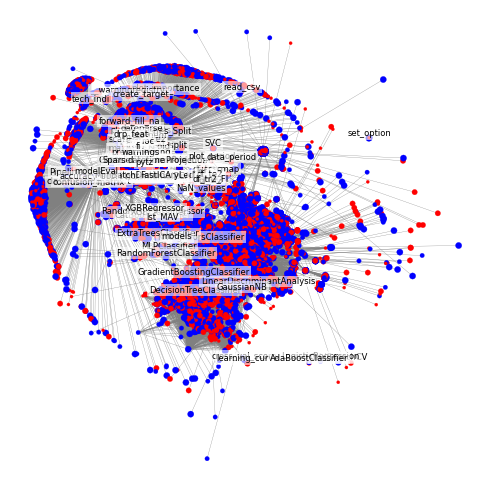

In [423]:
def save_fig(fig, save_path, ax=None):
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    if ax is None:
        fig.savefig(save_path)
    else:
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(save_path, bbox_inches=extent)
    print(f"Saved to {save_path}")

def plot_all(subset_node_ids, subset_edges, save_path=None):
    node_attributes = {
        n: {'size': (idx % 4 + 1) * 5, 'color': 'red' if idx % 2 == 0 else 'blue'}
        for idx, n in enumerate(subset_node_ids)
    }
    print(f"Selected subgraph of {len(subset_node_ids)} nodes, {len(subset_edges)} edges")
    
    # Draw the subset
    fig, ax = plt.subplots(figsize=(5, 5))
    plotter_draw_graph(plotter, ax, subset_node_ids, subset_edges, node_attributes, name_to_id_map=vname_map_at[dfc["dump_th"].max()], node_kwargs={"alpha": 1.0}, edge_kwargs={"alpha": 1.0})
    ax.axis('off')
    fig.tight_layout()
    if save_path is not None:
        save_fig(fig, save_path + ".svg")
        save_fig(fig, save_path + ".png")
    fig.show()

plot_all(
    all_node_ids,
    all_edges,
    save_path=f"{SAVE_DIR}/all_5",
)

[at= 0] Selected subgraph of 638 nodes, 788 edges
[at= 41] Selected subgraph of 23235 nodes, 7025 edges


/var/folders/mq/s_mr5r6931595yybcg6bk32w0000gp/T/ipykernel_31624/611382881.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


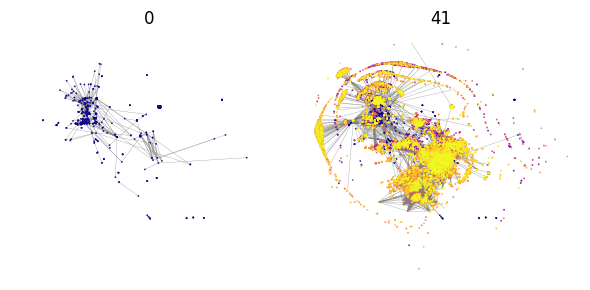

In [416]:
def plot_changed_before(plotter, ats, color_mean="last_change", plot_name=False, show=True, save_path=None):
    cmap = plt.cm.plasma
    norm = plt.Normalize(vmin=dfc["dump_th"].min(), vmax=dfc["dump_th"].max())
    size_map = get_size_map()
    size_norm = plt.Normalize(vmin=dff["size"].min(), vmax=dff["size"].max())

    SZ = 3
    M = min(len(ats), 5)
    N = (len(ats) - 1) // M + 1
    fig, axs = plt.subplots(nrows=N, ncols=M, figsize=(SZ*M, SZ*N))
    if len(ats) > 1:
        axs = axs.flatten()
    else:
        axs = [axs]
    for ax, at in zip(axs, ats):
        last_changed_dump_th = get_last_changed_dump_th(at)
        subset_node_ids = sorted(list(last_changed_dump_th), key=lambda x: last_changed_dump_th[x])
        subset_node_ids_set = set(subset_node_ids)
        subset_edges = get_edges(subset_node_ids_set, at)
        node_attributes = {}
        for idx, oid in enumerate(subset_node_ids):
            node_attributes[oid] = {}
            # node_attributes[oid]['size'] = size_norm(size_map[oid]) * 5 + 1,
            node_attributes[oid]['size'] = 1
            if color_mean == "last_change":
                node_attributes[oid]['color'] = cmap(norm(last_changed_dump_th[oid]))
            elif color_mean == "change":
                node_attributes[oid]['color'] = "#ff7f0e" if last_changed_dump_th[oid] == at else "#1f77b4"
            else:
                raise ValueError(f"Unknown color_mean {color_mean}")
        print(f"[at= {at}] Selected subgraph of {len(subset_node_ids)} nodes, {len(subset_edges)} edges")

        if plot_name:
            name_to_id_map = vname_map_at.get(at, {})
            name_to_id_map = {vname: oid for vname, oid in name_to_id_map.items() if last_changed_dump_th[oid] == at}
        else:
            name_to_id_map = {}
        
        # Draw the subset
        plotter_draw_graph(
            plotter,
            ax,
            subset_node_ids,
            subset_edges,
            node_attributes,
            name_to_id_map=name_to_id_map,
            node_kwargs={"alpha": 1.0},
            edge_kwargs={"alpha": 1.0},
        )
        if show:
            ax.set_title(f"{at}")
        ax.axis('off')
    for ax in axs[len(ats):]:
        ax.axis('off')
    fig.tight_layout()

    # Plot color bar
    # if color_mean == "last_change":
    #     fig, ax = plt.subplots(figsize=(SZ*M, 0.25))
    #     matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')

    if save_path is not None:
        save_fig(fig, save_path + ".svg")
        save_fig(fig, save_path + ".png")
    if show:
        fig.show()
    else:
        plt.clf()

plot_changed_before(plotter, [0, dfc["dump_th"].max()])

[at= 0] Selected subgraph of 638 nodes, 788 edges
[at= 10] Selected subgraph of 2805 nodes, 1351 edges
[at= 20] Selected subgraph of 5859 nodes, 2209 edges
[at= 30] Selected subgraph of 12682 nodes, 6619 edges
[at= 41] Selected subgraph of 23235 nodes, 7025 edges
Saved to netviz/buildats_2/hot5.svg
Saved to netviz/buildats_2/hot5.png


/var/folders/mq/s_mr5r6931595yybcg6bk32w0000gp/T/ipykernel_31624/611382881.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[at= 0] Selected subgraph of 638 nodes, 788 edges
Saved to netviz/buildats_2/hot5_0.svg
Saved to netviz/buildats_2/hot5_0.png
[at= 10] Selected subgraph of 2805 nodes, 1351 edges
Saved to netviz/buildats_2/hot5_10.svg
Saved to netviz/buildats_2/hot5_10.png
[at= 20] Selected subgraph of 5859 nodes, 2209 edges
Saved to netviz/buildats_2/hot5_20.svg
Saved to netviz/buildats_2/hot5_20.png
[at= 30] Selected subgraph of 12682 nodes, 6619 edges
Saved to netviz/buildats_2/hot5_30.svg
Saved to netviz/buildats_2/hot5_30.png
[at= 41] Selected subgraph of 23235 nodes, 7025 edges
Saved to netviz/buildats_2/hot5_41.svg
Saved to netviz/buildats_2/hot5_41.png


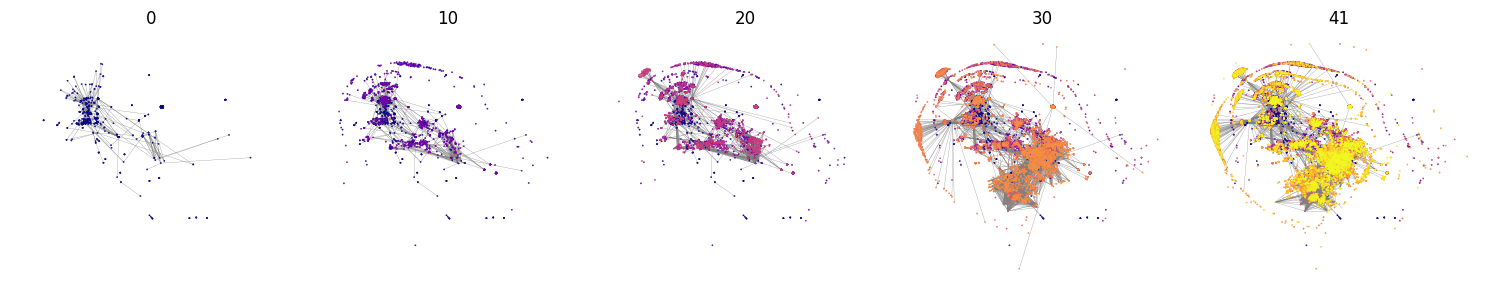

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [417]:
ats = [0, dfc["dump_th"].max() // 4, dfc["dump_th"].max() * 2 // 4, dfc["dump_th"].max() * 3 // 4, dfc["dump_th"].max()]
plot_changed_before(
    plotter,
    ats,
    save_path=f"{SAVE_DIR}/hot5",
)
for at in ats:
    plot_changed_before(
        plotter,
        [at],
        show=False,
        save_path=f"{SAVE_DIR}/hot5_{at}",
    )

[at= 0] Selected subgraph of 638 nodes, 788 edges
[at= 1] Selected subgraph of 824 nodes, 835 edges
[at= 2] Selected subgraph of 1072 nodes, 946 edges
[at= 3] Selected subgraph of 1245 nodes, 944 edges
[at= 4] Selected subgraph of 1452 nodes, 1040 edges
[at= 5] Selected subgraph of 1675 nodes, 1111 edges
[at= 6] Selected subgraph of 1877 nodes, 1111 edges
[at= 7] Selected subgraph of 2096 nodes, 1135 edges
[at= 8] Selected subgraph of 2320 nodes, 1135 edges
[at= 9] Selected subgraph of 2526 nodes, 1135 edges
[at= 10] Selected subgraph of 2805 nodes, 1351 edges
[at= 11] Selected subgraph of 3039 nodes, 1354 edges
[at= 12] Selected subgraph of 3302 nodes, 1448 edges
[at= 13] Selected subgraph of 3554 nodes, 1402 edges
[at= 14] Selected subgraph of 3794 nodes, 1410 edges
[at= 15] Selected subgraph of 4063 nodes, 1493 edges
[at= 16] Selected subgraph of 4416 nodes, 1682 edges
[at= 17] Selected subgraph of 4751 nodes, 1773 edges
[at= 18] Selected subgraph of 5189 nodes, 2209 edges
[at= 19] 

/var/folders/mq/s_mr5r6931595yybcg6bk32w0000gp/T/ipykernel_31624/611382881.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[at= 0] Selected subgraph of 638 nodes, 788 edges
Saved to netviz/buildats_2/changeall_0.svg
Saved to netviz/buildats_2/changeall_0.png
[at= 1] Selected subgraph of 824 nodes, 835 edges
Saved to netviz/buildats_2/changeall_1.svg
Saved to netviz/buildats_2/changeall_1.png
[at= 2] Selected subgraph of 1072 nodes, 946 edges
Saved to netviz/buildats_2/changeall_2.svg
Saved to netviz/buildats_2/changeall_2.png
[at= 3] Selected subgraph of 1245 nodes, 944 edges
Saved to netviz/buildats_2/changeall_3.svg
Saved to netviz/buildats_2/changeall_3.png
[at= 4] Selected subgraph of 1452 nodes, 1040 edges
Saved to netviz/buildats_2/changeall_4.svg
Saved to netviz/buildats_2/changeall_4.png
[at= 5] Selected subgraph of 1675 nodes, 1111 edges
Saved to netviz/buildats_2/changeall_5.svg
Saved to netviz/buildats_2/changeall_5.png
[at= 6] Selected subgraph of 1877 nodes, 1111 edges
Saved to netviz/buildats_2/changeall_6.svg
Saved to netviz/buildats_2/changeall_6.png
[at= 7] Selected subgraph of 2096 nodes,

/var/folders/mq/s_mr5r6931595yybcg6bk32w0000gp/T/ipykernel_31624/611382881.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=N, ncols=M, figsize=(SZ*M, SZ*N))


[at= 19] Selected subgraph of 5522 nodes, 2205 edges
Saved to netviz/buildats_2/changeall_19.svg
Saved to netviz/buildats_2/changeall_19.png
[at= 20] Selected subgraph of 5859 nodes, 2209 edges
Saved to netviz/buildats_2/changeall_20.svg
Saved to netviz/buildats_2/changeall_20.png
[at= 21] Selected subgraph of 6206 nodes, 2233 edges
Saved to netviz/buildats_2/changeall_21.svg
Saved to netviz/buildats_2/changeall_21.png
[at= 22] Selected subgraph of 6557 nodes, 2282 edges
Saved to netviz/buildats_2/changeall_22.svg
Saved to netviz/buildats_2/changeall_22.png
[at= 23] Selected subgraph of 6956 nodes, 2293 edges
Saved to netviz/buildats_2/changeall_23.svg
Saved to netviz/buildats_2/changeall_23.png
[at= 24] Selected subgraph of 7409 nodes, 2493 edges
Saved to netviz/buildats_2/changeall_24.svg
Saved to netviz/buildats_2/changeall_24.png
[at= 25] Selected subgraph of 7919 nodes, 2816 edges
Saved to netviz/buildats_2/changeall_25.svg
Saved to netviz/buildats_2/changeall_25.png
[at= 26] Sele

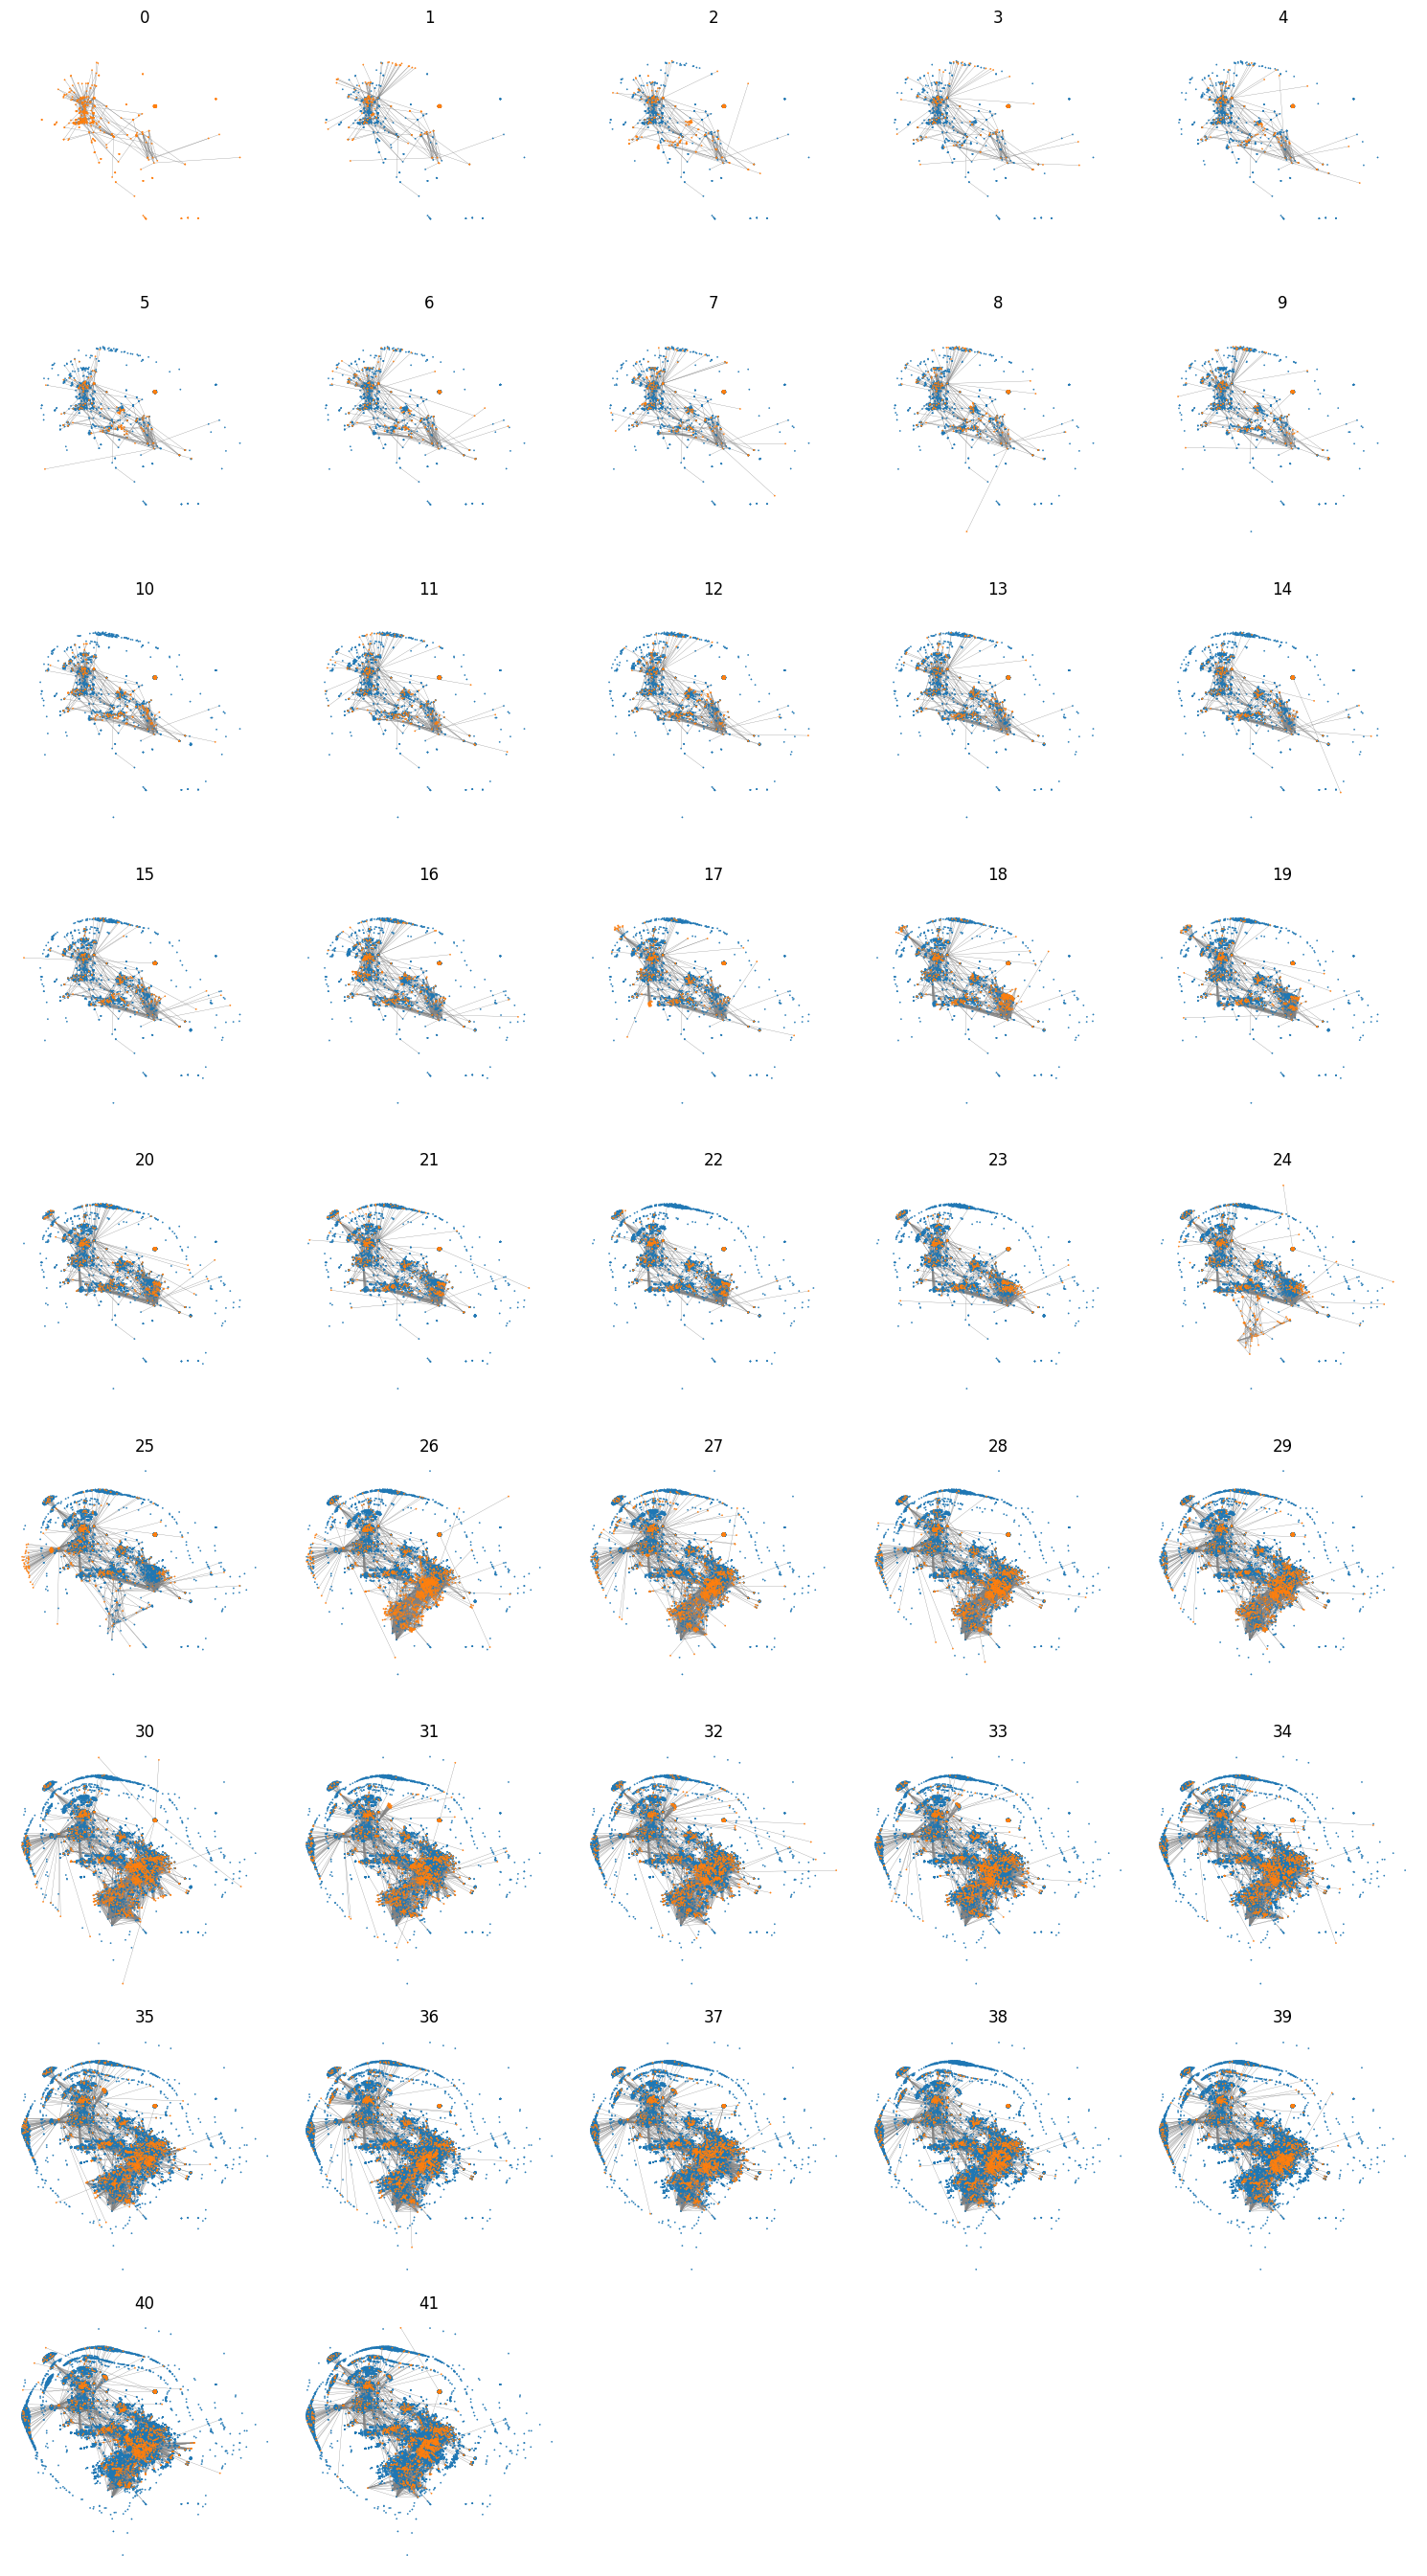

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [418]:
ats = list(range(dfc["dump_th"].max() + 1))
plot_changed_before(
    plotter,
    ats,
    color_mean="change",
    save_path=f"{SAVE_DIR}/changeall",
)
for at in ats:
    plot_changed_before(
        plotter,
        [at],
        color_mean="change",
        show=False,
        save_path=f"{SAVE_DIR}/changeall_{at}",
    )

[at= 0] Selected subgraph of 638 nodes, 788 edges
[at= 1] Selected subgraph of 824 nodes, 835 edges
[at= 2] Selected subgraph of 1072 nodes, 946 edges
[at= 3] Selected subgraph of 1245 nodes, 944 edges
[at= 4] Selected subgraph of 1452 nodes, 1040 edges
[at= 5] Selected subgraph of 1675 nodes, 1111 edges
[at= 6] Selected subgraph of 1877 nodes, 1111 edges
[at= 7] Selected subgraph of 2096 nodes, 1135 edges
[at= 8] Selected subgraph of 2320 nodes, 1135 edges
[at= 9] Selected subgraph of 2526 nodes, 1135 edges
[at= 10] Selected subgraph of 2805 nodes, 1351 edges
[at= 11] Selected subgraph of 3039 nodes, 1354 edges
[at= 12] Selected subgraph of 3302 nodes, 1448 edges
[at= 13] Selected subgraph of 3554 nodes, 1402 edges
[at= 14] Selected subgraph of 3794 nodes, 1410 edges
[at= 15] Selected subgraph of 4063 nodes, 1493 edges
[at= 16] Selected subgraph of 4416 nodes, 1682 edges
[at= 17] Selected subgraph of 4751 nodes, 1773 edges
[at= 18] Selected subgraph of 5189 nodes, 2209 edges
[at= 19] 

/var/folders/mq/s_mr5r6931595yybcg6bk32w0000gp/T/ipykernel_31624/611382881.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[at= 0] Selected subgraph of 638 nodes, 788 edges
Saved to netviz/buildats_2/changeall_named_0.svg
Saved to netviz/buildats_2/changeall_named_0.png
[at= 1] Selected subgraph of 824 nodes, 835 edges
Saved to netviz/buildats_2/changeall_named_1.svg
Saved to netviz/buildats_2/changeall_named_1.png
[at= 2] Selected subgraph of 1072 nodes, 946 edges
Saved to netviz/buildats_2/changeall_named_2.svg
Saved to netviz/buildats_2/changeall_named_2.png
[at= 3] Selected subgraph of 1245 nodes, 944 edges
Saved to netviz/buildats_2/changeall_named_3.svg
Saved to netviz/buildats_2/changeall_named_3.png
[at= 4] Selected subgraph of 1452 nodes, 1040 edges
Saved to netviz/buildats_2/changeall_named_4.svg
Saved to netviz/buildats_2/changeall_named_4.png
[at= 5] Selected subgraph of 1675 nodes, 1111 edges
Saved to netviz/buildats_2/changeall_named_5.svg
Saved to netviz/buildats_2/changeall_named_5.png
[at= 6] Selected subgraph of 1877 nodes, 1111 edges
Saved to netviz/buildats_2/changeall_named_6.svg
Saved

/var/folders/mq/s_mr5r6931595yybcg6bk32w0000gp/T/ipykernel_31624/611382881.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=N, ncols=M, figsize=(SZ*M, SZ*N))


[at= 19] Selected subgraph of 5522 nodes, 2205 edges
Saved to netviz/buildats_2/changeall_named_19.svg
Saved to netviz/buildats_2/changeall_named_19.png
[at= 20] Selected subgraph of 5859 nodes, 2209 edges
Saved to netviz/buildats_2/changeall_named_20.svg
Saved to netviz/buildats_2/changeall_named_20.png
[at= 21] Selected subgraph of 6206 nodes, 2233 edges
Saved to netviz/buildats_2/changeall_named_21.svg
Saved to netviz/buildats_2/changeall_named_21.png
[at= 22] Selected subgraph of 6557 nodes, 2282 edges
Saved to netviz/buildats_2/changeall_named_22.svg
Saved to netviz/buildats_2/changeall_named_22.png
[at= 23] Selected subgraph of 6956 nodes, 2293 edges
Saved to netviz/buildats_2/changeall_named_23.svg
Saved to netviz/buildats_2/changeall_named_23.png
[at= 24] Selected subgraph of 7409 nodes, 2493 edges
Saved to netviz/buildats_2/changeall_named_24.svg
Saved to netviz/buildats_2/changeall_named_24.png
[at= 25] Selected subgraph of 7919 nodes, 2816 edges
Saved to netviz/buildats_2/ch

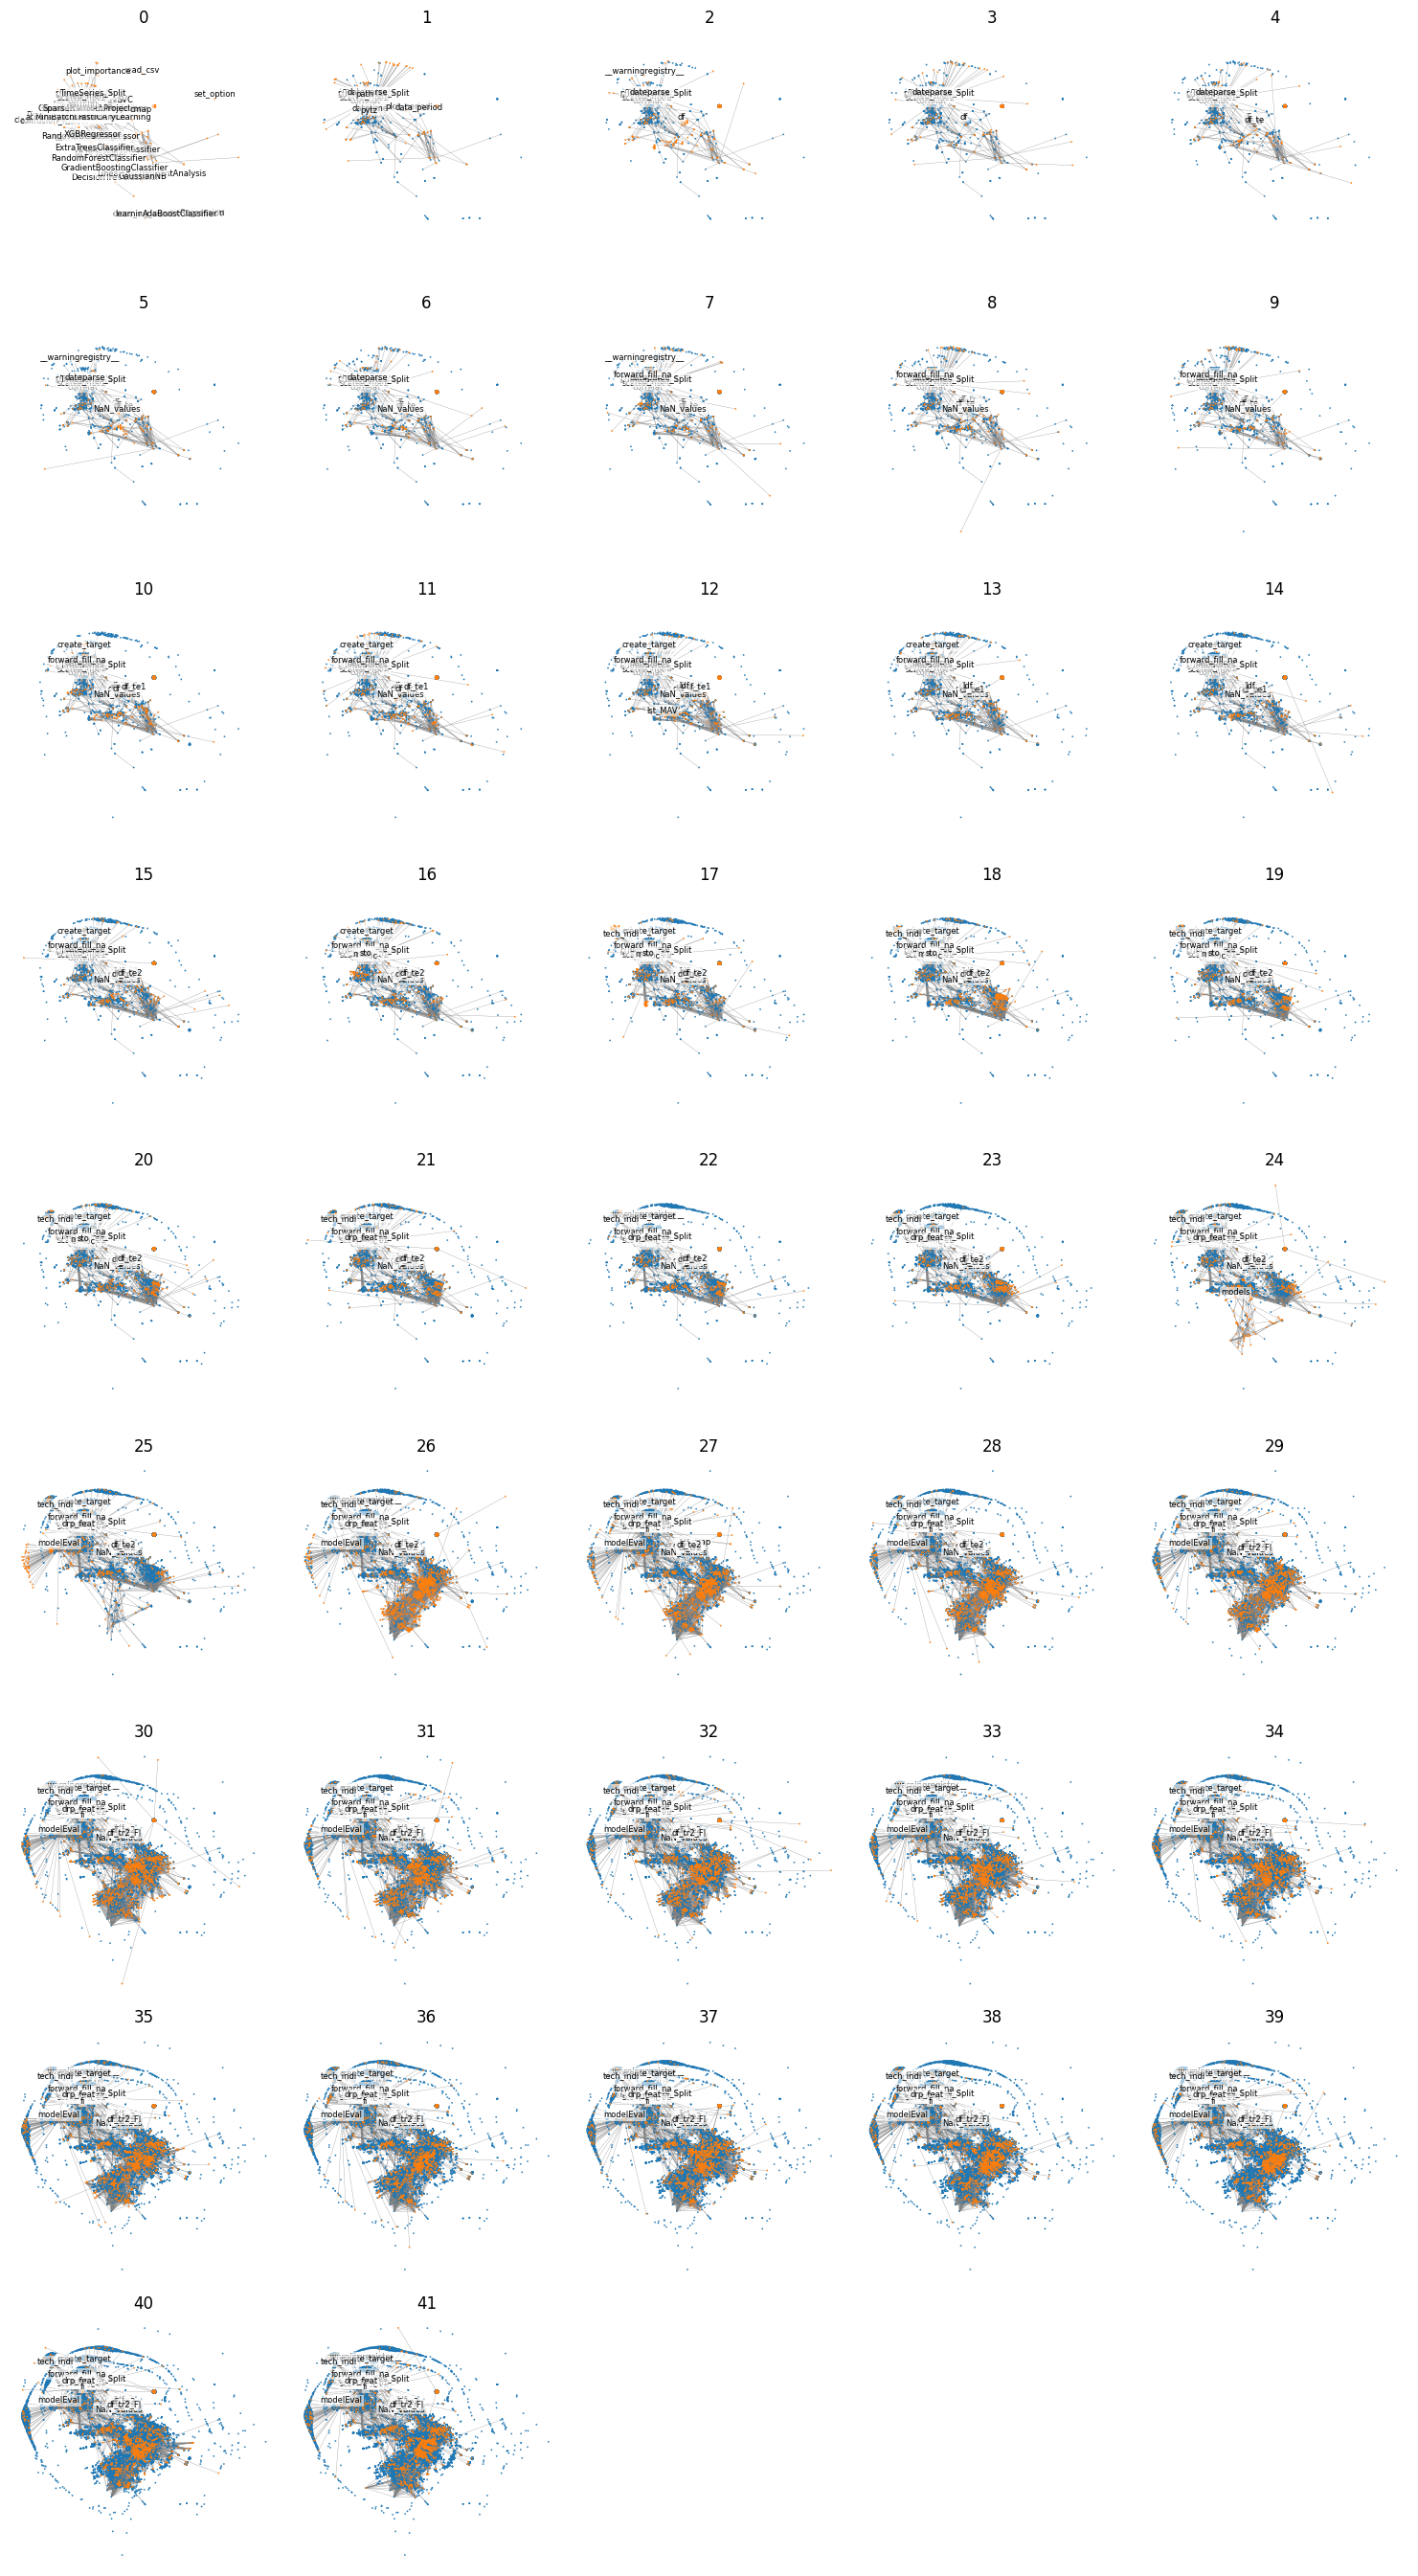

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [419]:
ats = list(range(dfc["dump_th"].max() + 1))
plot_changed_before(
    plotter,
    ats,
    color_mean="change",
    plot_name=True,
    save_path=f"{SAVE_DIR}/changeall_named",
)
for at in ats:
    plot_changed_before(
        plotter,
        [at],
        color_mean="change",
        plot_name=True,
        show=False,
        save_path=f"{SAVE_DIR}/changeall_named_{at}",
    )

[at= 0] Selected subgraph of 638 nodes, 788 edges
[at= 0] Selected subgraph of 638 nodes, 788 edges
[at= 41] Selected subgraph of 23235 nodes, 7025 edges


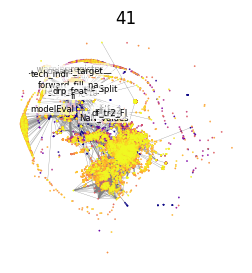

In [420]:
def animate_changed_before(plotter, ats, color_mean="last_change", SZ=3, plot_name=True, save_path=None):
    cmap = plt.cm.plasma
    norm = plt.Normalize(vmin=dfc["dump_th"].min(), vmax=dfc["dump_th"].max())
    size_map = get_size_map()
    size_norm = plt.Normalize(vmin=dff["size"].min(), vmax=dff["size"].max())

    M = 1
    N = 1
    fig, ax = plt.subplots(nrows=N, ncols=M, figsize=(SZ*M, SZ*N))

    def update(frame_idx):
        ax.clear()
        at = ats[frame_idx]
        last_changed_dump_th = get_last_changed_dump_th(at)
        subset_node_ids = sorted(list(last_changed_dump_th), key=lambda x: last_changed_dump_th[x])
        subset_node_ids_set = set(subset_node_ids)
        subset_edges = get_edges(subset_node_ids_set, at)
        node_attributes = {}
        for idx, oid in enumerate(subset_node_ids):
            node_attributes[oid] = {}
            # node_attributes[oid]['size'] = size_norm(size_map[oid]) * 5 + 1,
            node_attributes[oid]['size'] = 1
            if color_mean == "last_change":
                node_attributes[oid]['color'] = cmap(norm(last_changed_dump_th[oid]))
            elif color_mean == "change":
                node_attributes[oid]['color'] = "#ff7f0e" if last_changed_dump_th[oid] == at else "#1f77b4"
            else:
                raise ValueError(f"Unknown color_mean {color_mean}")
        print(f"[at= {at}] Selected subgraph of {len(subset_node_ids)} nodes, {len(subset_edges)} edges")

        # variable names
        if plot_name:
            name_to_id_map = vname_map_at.get(at, {})
            name_to_id_map = {vname: oid for vname, oid in name_to_id_map.items() if last_changed_dump_th[oid] == at}
        else:
            name_to_id_map = {}
        
        # Draw the subset
        plotter_draw_graph(
            plotter,
            ax,
            subset_node_ids,
            subset_edges,
            node_attributes,
            name_to_id_map=name_to_id_map,
            node_kwargs={"alpha": 1.0},
            edge_kwargs={"alpha": 1.0},
        )
        ax.set_title(f"{at}")
        ax.axis('off')
    
    ani = animation.FuncAnimation(fig, update, frames=len(ats), interval=300)
    ani.save(save_path, fps=3, dpi=150)
    plt.show()

animate_changed_before(
    plotter,
    [0, dfc["dump_th"].max()],
    save_path="netviz.mp4",
)

[at= 0] Selected subgraph of 638 nodes, 788 edges
[at= 0] Selected subgraph of 638 nodes, 788 edges
[at= 1] Selected subgraph of 824 nodes, 835 edges
[at= 2] Selected subgraph of 1072 nodes, 946 edges
[at= 3] Selected subgraph of 1245 nodes, 944 edges
[at= 4] Selected subgraph of 1452 nodes, 1040 edges
[at= 5] Selected subgraph of 1675 nodes, 1111 edges
[at= 6] Selected subgraph of 1877 nodes, 1111 edges
[at= 7] Selected subgraph of 2096 nodes, 1135 edges
[at= 8] Selected subgraph of 2320 nodes, 1135 edges
[at= 9] Selected subgraph of 2526 nodes, 1135 edges
[at= 10] Selected subgraph of 2805 nodes, 1351 edges
[at= 11] Selected subgraph of 3039 nodes, 1354 edges
[at= 12] Selected subgraph of 3302 nodes, 1448 edges
[at= 13] Selected subgraph of 3554 nodes, 1402 edges
[at= 14] Selected subgraph of 3794 nodes, 1410 edges
[at= 15] Selected subgraph of 4063 nodes, 1493 edges
[at= 16] Selected subgraph of 4416 nodes, 1682 edges
[at= 17] Selected subgraph of 4751 nodes, 1773 edges
[at= 18] Sel

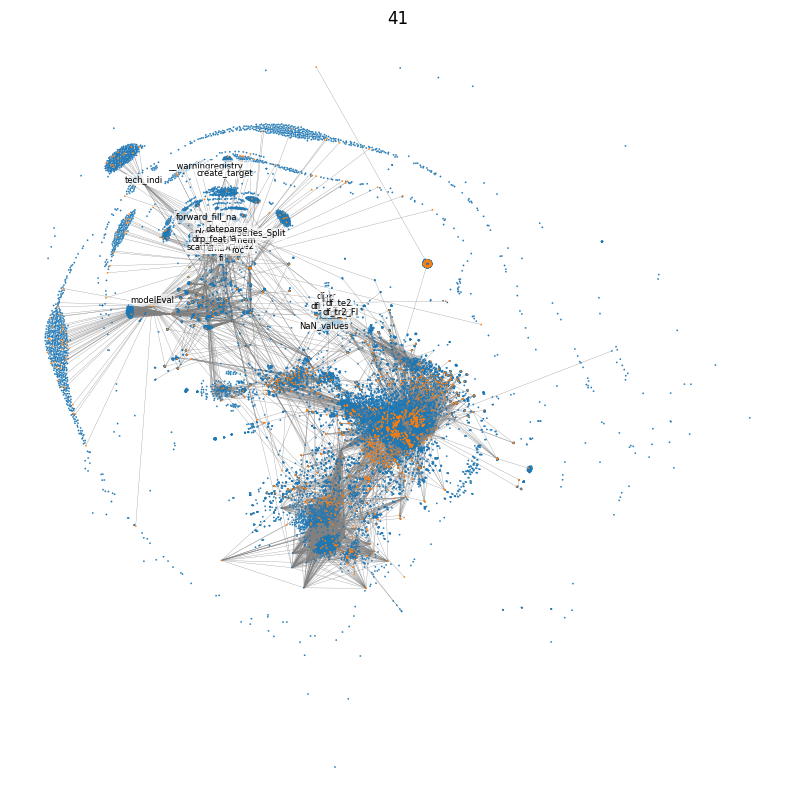

In [421]:
animate_changed_before(
    plotter,
    list(range(dfc["dump_th"].max() + 1)),
    color_mean="change",
    SZ=10,
    plot_name=True,
    save_path=f"{SAVE_DIR}/netviz.mp4",
)

[at= 0] Selected subgraph of 638 nodes, 788 edges
[at= 0] Selected subgraph of 638 nodes, 788 edges
[at= 1] Selected subgraph of 824 nodes, 835 edges
[at= 2] Selected subgraph of 1072 nodes, 946 edges
[at= 3] Selected subgraph of 1245 nodes, 944 edges
[at= 4] Selected subgraph of 1452 nodes, 1040 edges
[at= 5] Selected subgraph of 1675 nodes, 1111 edges
[at= 6] Selected subgraph of 1877 nodes, 1111 edges
[at= 7] Selected subgraph of 2096 nodes, 1135 edges
[at= 8] Selected subgraph of 2320 nodes, 1135 edges
[at= 9] Selected subgraph of 2526 nodes, 1135 edges
[at= 10] Selected subgraph of 2805 nodes, 1351 edges
[at= 11] Selected subgraph of 3039 nodes, 1354 edges
[at= 12] Selected subgraph of 3302 nodes, 1448 edges
[at= 13] Selected subgraph of 3554 nodes, 1402 edges
[at= 14] Selected subgraph of 3794 nodes, 1410 edges
[at= 15] Selected subgraph of 4063 nodes, 1493 edges
[at= 16] Selected subgraph of 4416 nodes, 1682 edges
[at= 17] Selected subgraph of 4751 nodes, 1773 edges
[at= 18] Sel

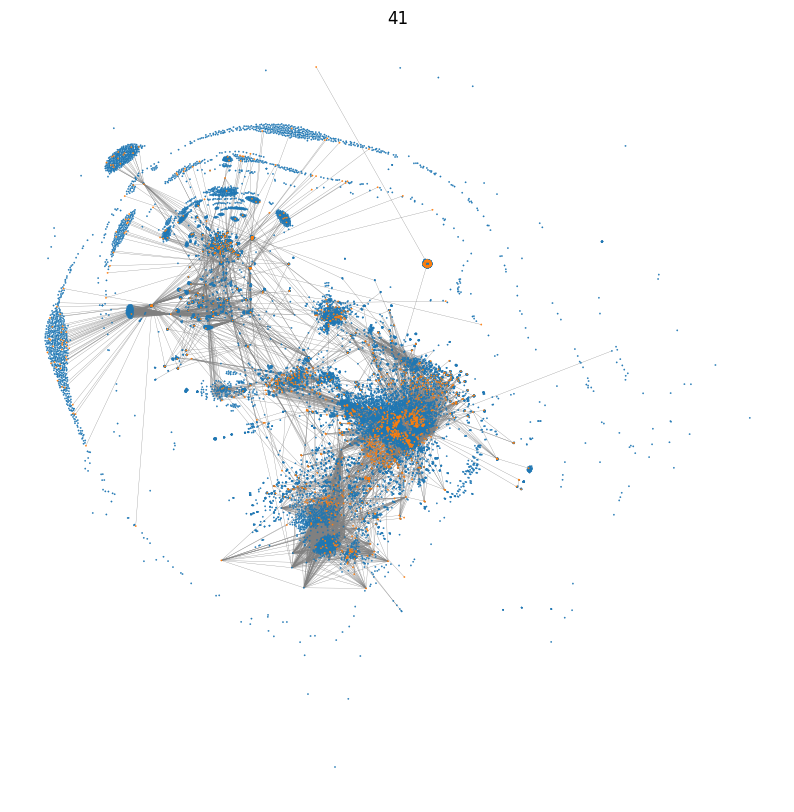

In [422]:
animate_changed_before(
    plotter,
    list(range(dfc["dump_th"].max() + 1)),
    color_mean="change",
    SZ=10,
    plot_name=False,
    save_path=f"{SAVE_DIR}/netviz_noname.mp4",
)

Created 1000 nodes with 3000 edges
Assigned coordinates (2.4693517684936523 seconds)
Selected subgraph


/var/folders/mq/s_mr5r6931595yybcg6bk32w0000gp/T/ipykernel_80368/3772251054.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


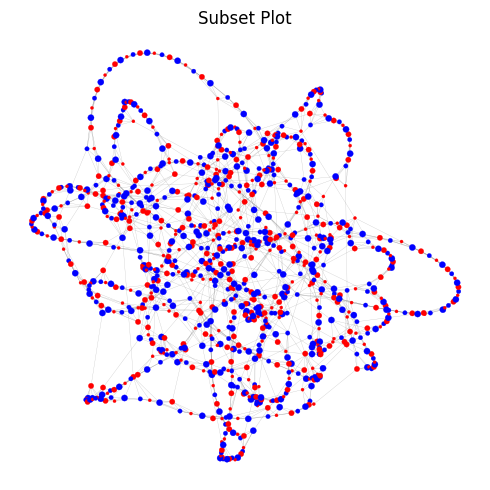

In [137]:
def test_plotter():
    # Setup full graph space
    N = 1_000
    G = nx.watts_strogatz_graph(n=N, k=6, p=0.05, seed=42)
    all_edges = list(G.edges())
    all_node_ids = list(G.nodes())
    print(f"Created {len(all_node_ids)} nodes with {len(all_edges)} edges")
    
    # Create plotter
    start_ts = time.time()
    plotter = GraphPlotter(all_node_ids, all_edges)
    end_ts = time.time()
    print(f"Assigned coordinates ({end_ts - start_ts} seconds)")
    
    # Later: plot a subset
    subset_node_ids = list(range(0, N))
    subset_edges = [edge for edge in all_edges if edge[0] in subset_node_ids and edge[1] in subset_node_ids]
    node_attributes = {
        i: {'size': (i % 4 + 1) * 5, 'color': 'red' if i % 2 == 0 else 'blue'}
        for i in subset_node_ids
    }
    print(f"Selected subgraph")
    
    # Draw the subset
    fig, ax = plt.subplots(figsize=(5, 5))
    plotter.draw(ax, subset_node_ids, subset_edges, node_attributes)
    ax.set_title("Subset Plot")
    ax.axis('off')
    fig.tight_layout()
    fig.show()

test_plotter()